# **The Navier-Stokes equations**
**Kevin Arnmark**

# **Abstract**

This report shows a method on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology. The report describes the effects of changing the reynolds number and mesh resolution of the simulation in terms of the Strauhaul number and different force coefficients. It also includes an animation visualizing the von Karman vortex street using the software Paraview.

# **About the code**

In [ ]:
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.

from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a function for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)

# Lab assignments
In this report I implement the following assignments and answer the following questions:

1. **Reynolds number**

  Compute the Reynolds number based on the inflow velocity U and the diameter D of the cylinder. Compare simulations for Reynolds numbers Re = 1, 10, 100, 1000. For which Reynolds numbers is the flow unsteady and steady, respectively? 

2. **Drag and lift coefficients**

  Compute the drag and lift coefficients, and the Strouhal number, for the cylinder at the different Reynolds numbers (Re = 1, 10, 100, 1000). Verify that the von Karman vortex street has a Strouhal number of St≈0.2. 

3. **Mesh resolution**

  Compare the solution for Re=100 under the different mesh resolutions h=1/8, 1/16, 1/32. Describe how the simulations change with respect to drag and lift coefficients and the Strouhal number. 

4. **Paraview visualization (Extra)**

  Create movies of the simulation for Re=100 and h=1/32, by using the open source software Paraview.


# **Method**

1. The Reynolds number is computed using $Re=\frac{UD}{\nu}$. To change this number to 1, 10, 100 & 1000 I choose to vary the viscosity and keep the velocity and diameter of the circle at $U = 1.0, D = 0.4$. 

2. The strauhaul number is defined as $St = \frac{fL}{U}$, where $L$ in this case is the diameter of the circle, $f$ is the frequency of the oscillation in the lift force and $U$ is the free stream velocity. I created a function to calculate the frequency of the resulting lift force. The function is not universal and only works in simulations where the force oscillates between negative and positive numbers, which is the case for these simulations. The drag and lift coefficients are computed by calculating the force on the circle in either the x-direction or y-direction using the force equation described in the background and normalizing it by $c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}$.

3. To get the desired effect I kept the Reynolds number at 100 and varied the mesh resolution between 8, 16 & 32.

4. To generate the animation of the simulation I exported the resulting solutions and imported them into Paraview, where I created the video.

To ease the testing process and to be able to visualize all variations of the simulation in the results of this report I created a function that does the entire simulation, where the inputs are the viscosity nu and the mesh resolution along with some booleans to enable or disable visualization of relevant parts. The code is set up to only plot and print at the last timestep (30s).

In [ ]:
def simulate(nu, res, vis_mesh=False, vis_force=False):
  ###
  # Define domain and mesh
  ###

  # Define rectangular domain 
  L = 4
  H = 2

  # Define circle
  xc = 1.0
  yc = 0.5*H
  rc = 0.2

  # Parameters
  inflow_vel = 1.0

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0) 

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)
        
  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh (examples with and without a hole in the mesh) 
  resolution = res
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc, resolution), resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

  # Calculating the Reynolds Number and printing information about the simulation
  re = (inflow_vel*rc*2)/nu
  print("Reynolds Number = ", re, "Mesh Resolution = 1/" + repr(res))

  if (vis_mesh):
    plt.figure()
    plot(mesh)
    plt.show()


  ###
  # Define finite element approximation spaces
  ###

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 1)
  Q = FunctionSpace(mesh, "Lagrange", 1)

  # Define trial and test functions 
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)


  ###
  # Define boundary conditions
  ###

  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0) 

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  # Examples of time dependent and stationary inflow conditions
  #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
  #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
  uin = inflow_vel
  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left) 
  bcp1 = DirichletBC(Q, pout, dbc_right)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration  
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


  ###
  # Define method parameters
  ###

  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step  
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and lienar solvers 
  num_nnlin_iter = 5 
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

  # Time step length 
  dt = 0.5*mesh.hmin() 


  ###
  # Define variational problem
  ###

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0)

  # Momentum variational equation on residual form
  Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
      + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
  ap = lhs(Fp)
  Lp = rhs(Fp)


  ###
  # Compute force on boundary
  ###

  # Define the direction of the force to be computed 
  phi_x = 0.0
  phi_y = 1.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi = interpolate(psi_expression, V)

  Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  phi_x = 1.0
  phi_y = 0.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  psi_expression_2 = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  psi_2 = interpolate(psi_expression_2, V)

  Force_2 = inner((u1 - u0)/dt + grad(um1)*um1, psi_2)*dx - p1*div(psi_2)*dx + nu*inner(grad(um1), grad(psi_2))*dx

  #plt.figure()
  #plot(psi, title="weight function psi")

  # Force normalization
  D = 2*rc
  #normalization = -2.0/D
  normalization = -2.0/(D*(uin**2))


  ###
  # Set plotting variables and open export files
  ###

  # Open files to export solution to Paraview
  file_u = File("results-NS/u.pvd")
  file_p = File("results-NS/p.pvd")

  # Set plot frequency
  plot_time = 0
  plot_freq = 10

  # Force computation data 
  force_array = np.array(0.0)
  force_array = np.delete(force_array, 0)
  force_array_2 = np.array(0.0)
  force_array_2 = np.delete(force_array_2, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0


  ###
  # Time stepping algorithm
  ###

  !rm results-NS/*

  # Time stepping 
  T = 30
  t = dt

  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t) 
      #print(s)

      #pin.t = t
      #uin.t = t

      # Solve non-linear problem 
      k = 0
      while k < num_nnlin_iter: 
          
          # Assemble momentum matrix and vector 
          Au = assemble(au)
          bu = assemble(Lu)

          # Compute velocity solution 
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(ap) 
          bp = assemble(Lp)

          # Compute pressure solution 
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)

          # Compute force
          F = assemble(Force)
          F_2 = assemble(Force_2)
          if (t > start_sample_time):
            force_array = np.append(force_array, normalization*F)
            force_array_2 = np.append(force_array_2, normalization*F_2)
            time = np.append(time, t)

          k += 1

      #if t > plot_time:

      # Update time step
      u0.assign(u1)
      t += dt
      

  s = 'Time t = ' + repr(int(t)) #Set plotting variables and open export files
  #print(s)
      
  # Save solution to file
  file_u << u1
  file_p << p1

  # Plot solution
  plt.figure()
  plot(u1, title="Velocity, " + s + ", Re = " + repr(re))

  plt.figure()
  plot(p1, title="Pressure, " + s + ", Re = " + repr(re))

  plot_time += T/plot_freq
          
  plt.show()

  if (vis_force):
    # Plot the lift force
    plt.figure()
    plt.title("Lift Force, " + s + ", Re = " + repr(re))
    plt.plot(time, force_array)

    # Plot the average of force_array
    lift_avg = np.array([sum(force_array) / len(force_array)]*len(time))
    plt.plot(time, lift_avg, color='red', label='avg = ' + "{:.3f}".format(lift_avg[0]))
    plt.legend()
    plt.show()

    # Plot the drag force
    plt.figure()
    plt.title("Drag Force, " + s + ", Re = " + repr(re))
    plt.plot(time, force_array_2)

    # Plot the average of force_array_2 during the last 5 seconds
    drag_avg = np.array([sum(force_array_2[int(len(force_array_2) * (T-5)/T):]) / len(force_array_2[int(len(force_array_2) * (T-5)/T):])]*len(time))
    plt.plot(time, drag_avg, color='red', label='avg = ' + "{:.3f}".format(drag_avg[0])) 
    plt.legend()
    plt.show()

  # Compute frequency when lift force is oscillating around 0
  # This is can also be used inside the time stepping loop to provide 
  # the strauhaul number for each plot. 
  # It has been moved here to only print at the end of each simulation.
  # Some parts of the code is therefore not used when placed here.
  start_t = -1
  end_t = 0
  if (t > start_sample_time):
    f_counter = 0
    before = force_array[0]
    for i in range(1, len(force_array)):
      if before > 0 and force_array[i] < 0: 
        if start_t < 0:
          start_t = time[i]
        f_counter += 1
        end_t = time[i]
      elif before < 0 and force_array[i] > 0:
        if start_t < 0:
          start_t = time[i]
        f_counter += 1
        end_t = time[i]
      before = force_array[i]
    if end_t - start_t > 0:
      freq = (f_counter / 2) / (end_t - start_t)
      print("Frequency of lift force oscillation: ", freq, " Hz")
      print("Strauhaul Number: ", (freq*2*rc)/uin, "\n")

  #!tar -czvf results-NS.tar.gz results-NS
  #files.download('results-NS.tar.gz')

# **Results**

1. **Reynolds number**

  Compute the Reynolds number based on the inflow velocity U and the diameter D of the cylinder. Compare simulations for Reynolds numbers Re = 1, 10, 100, 1000. For which Reynolds numbers is the flow unsteady and steady, respectively? 

  Changing the viscosity results in the reynolds number:

  $Re=1, \nu=4.0*10^{-1}$, 

  $Re=10, \nu=4.0*10^{-2}$, 

  $Re=100, \nu=4.0*10^{-3}$, 

  $Re=1000, \nu=4.0*10^{-4}$

2. **Drag and lift coefficients**

  Compute the drag and lift coefficients, and the Strouhal number, for the cylinder at the different Reynolds numbers (Re = 1, 10, 100, 1000). Verify that the von Karman vortex street has a Strouhal number of St≈0.2. 

Reynolds Number =  1.0 Mesh Resolution = 1/32
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


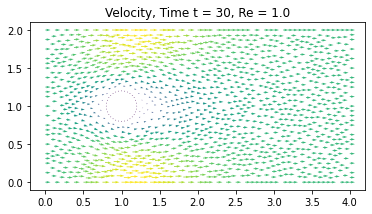

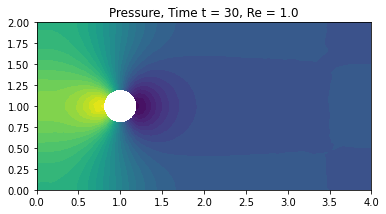

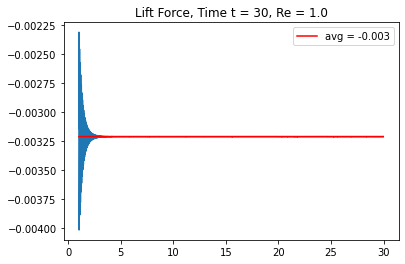

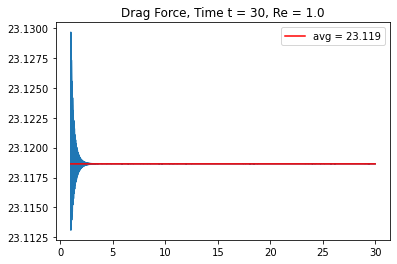

Frequency of lift force oscillation:  0.0  Hz
Strauhaul Number:  0.0 

Reynolds Number =  10.0 Mesh Resolution = 1/32
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


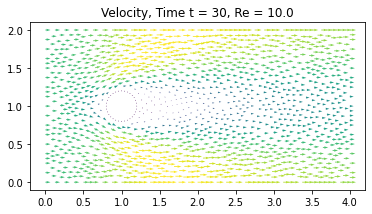

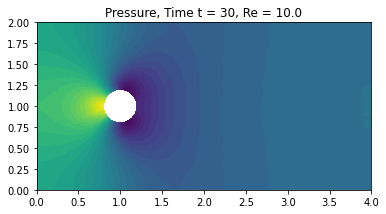

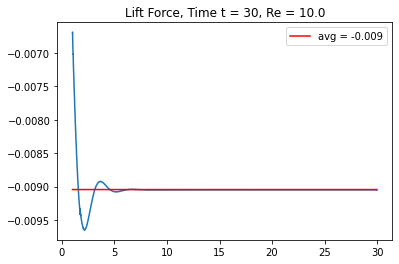

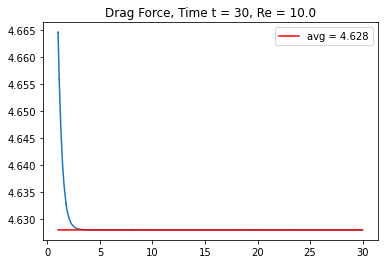

Frequency of lift force oscillation:  0.0  Hz
Strauhaul Number:  0.0 

Reynolds Number =  100.0 Mesh Resolution = 1/32
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


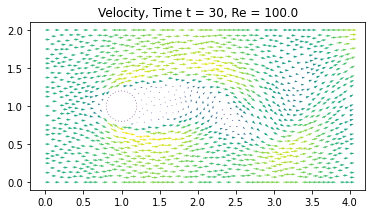

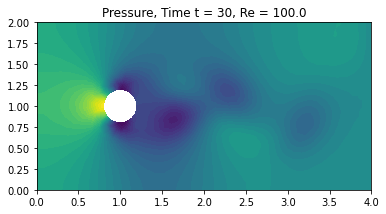

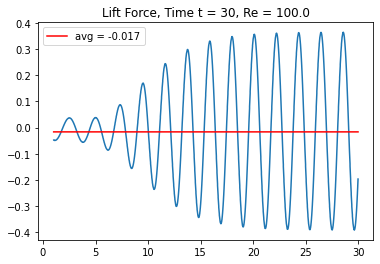

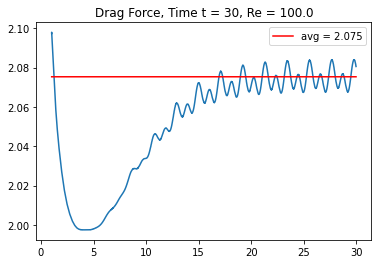

Frequency of lift force oscillation:  0.47819754318028374  Hz
Strauhaul Number:  0.1912790172721135 

Reynolds Number =  1000.0 Mesh Resolution = 1/32
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


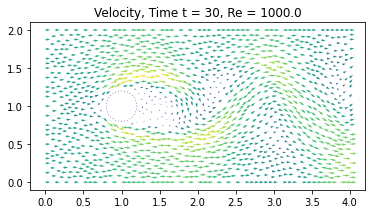

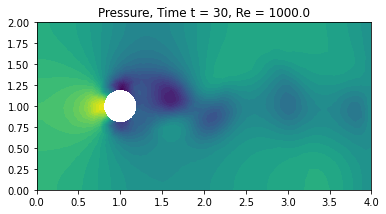

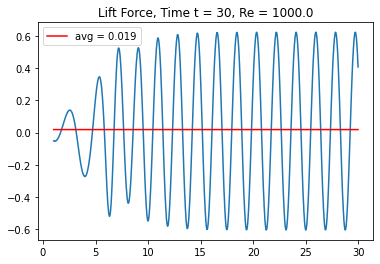

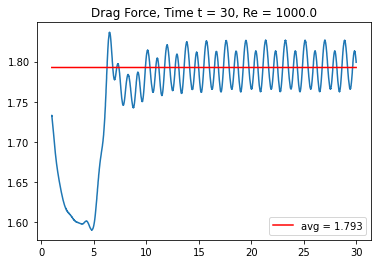

Frequency of lift force oscillation:  0.5262770851566023  Hz
Strauhaul Number:  0.21051083406264093 



In [ ]:
simulate(4e-1, 32, False, True)
simulate(4e-2, 32, False, True)
simulate(4e-3, 32, False, True)
simulate(4e-4, 32, False, True)

**Drag and lift coefficients**

I computed the drag and lift coefficents using the force visualized in the plots, which is already normalized using $F * -2.0/(D*u_{in}^2)$, where $F$ is the array with the force coefficient in each timestep, $D$ is the diameter of the circle and $u_{in}$ is the inflow velocity. For the lift coefficient I used the average value of the force since it is oscillating. The drag coefficient uses the average of the last 5 seconds of the simulation since the force oscillates and converges later in the simulation towards that average value. 

$Re=1$: 

$c_L\approx -0.003, c_D \approx 23.119$

$Re=10$: 

$c_L\approx -0.009, c_D\approx 4.628$

$Re=100$: 

$c_L \approx -0.017, c_D\approx 2.075$

$Re=1000$: 

$c_L\approx 0.019, c_D\approx 1.793$



3. **Mesh resolution**

  Compare the solution for Re=100 under the different mesh resolutions h=1/8, 1/16, 1/32. Describe how the simulations change with respect to drag and lift coefficients and the Strouhal number. 

Reynolds Number =  100.0 Mesh Resolution = 1/8


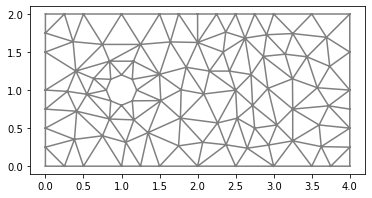

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


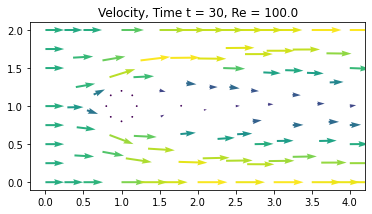

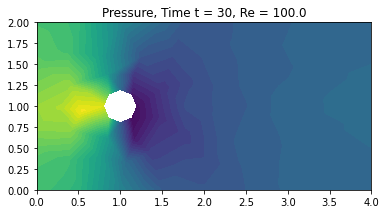

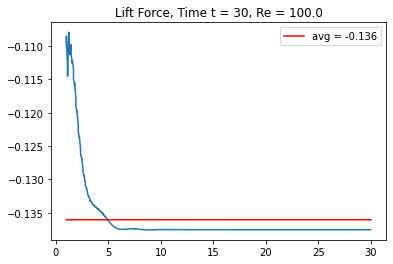

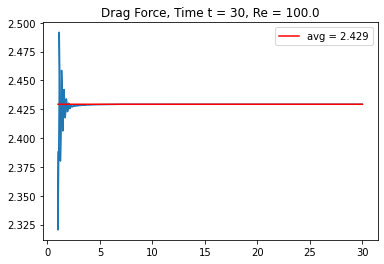

Frequency of lift force oscillation:  0.0  Hz
Strauhaul Number:  0.0 

Reynolds Number =  100.0 Mesh Resolution = 1/16


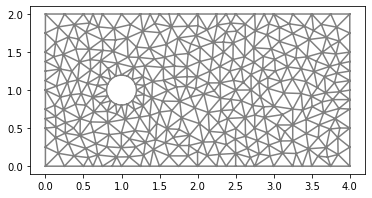

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


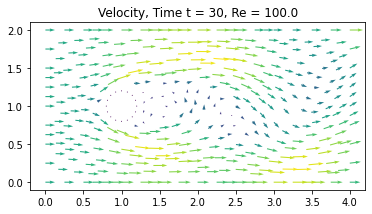

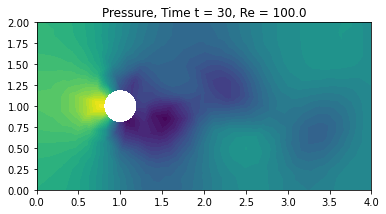

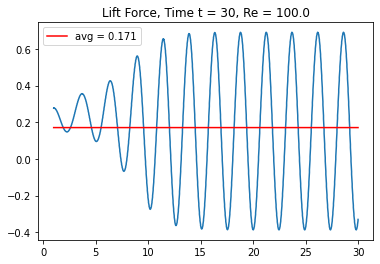

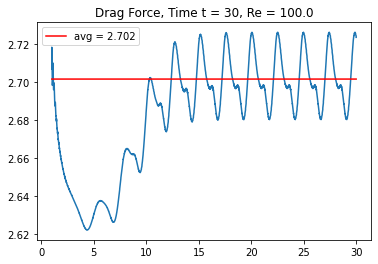

Frequency of lift force oscillation:  0.4338499674325168  Hz
Strauhaul Number:  0.17353998697300674 

Reynolds Number =  100.0 Mesh Resolution = 1/32


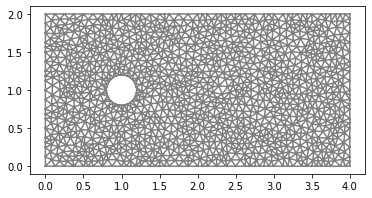

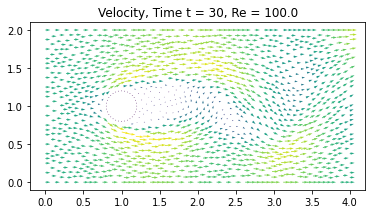

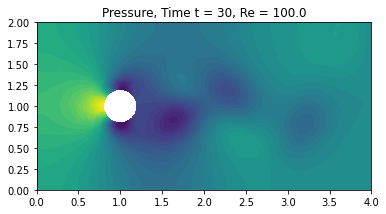

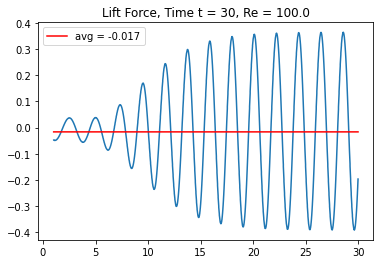

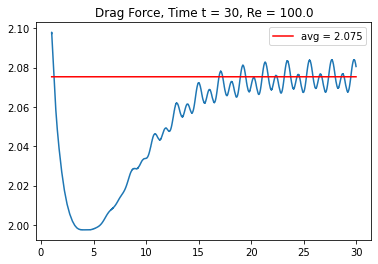

Frequency of lift force oscillation:  0.47819754318028374  Hz
Strauhaul Number:  0.1912790172721135 



In [ ]:
simulate(4e-3, 8, True, True)
simulate(4e-3, 16, True, True)
simulate(4e-3, 32, True, True)


4. **Paraview visualization (Extra)**

  Create movies of the simulation for Re=100 and h=1/32, by using the open source software Paraview.

  The videos can be found in the GitHub repository Lab2/kevinarnmark_video_u.mp4 & Lab2/kevinarnmark_video_p.mp4

# **Discussion**

**Question: For which Reynolds numbers is the flow unsteady and steady, respectively?**

At reynolds numbers 1 and 10, the flow is steady. When the Reynolds number is 100 and 1000 it is unsteady which can be seen in both the velocity and pressure solution plots where vortices are forming in the wake of the circle. 

**Drag and lift coefficients**

I believe the reason the average lift coefficients are not exactly zero is because the generated mesh is not completely symmetric and the circle is not perfectly round which results in a small lift force.

There seems to be a relationship between the reynolds number and the drag coefficient in these simulations. As the reynolds number grows the drag coefficient gets smaller. The amplitude of the oscillations in the lift force gets larger as the reynolds number gets larger when the von Karman vortex street has formed.

**Verify that the von Karman vortex street has a Strouhal number of St≈0.2.**

In the velocity and pressure plots the von Karman vortex street is visible when the Reynolds number is 100 or 1000. The calculations done verfies that with this setup, the von Karman vortex street forms and the Strauhaul number is approximately 0.2, which can be seen in the prints below the force plots. For $Re=100$ it was closer to 0.19, and $Re=1000$ it was closer to 0.21. Which could be explained by the turbulence not getting resolved accurately when the reynolds number is 1000 because the mesh is not fine enough the resolve the smaller turbulence features. It also varies depending on what resolution the circle has. When set to the default value of the template, the strauhaul number is closer to 0.20. 

**Compare the solution for Re=100 under the different mesh resolutions h=1/8, 1/16, 1/32. Describe how the simulations change with respect to drag and lift coefficients and the Strouhal number.**

When $h=1/8$ the resolution of the mesh is low enough that no vortices forms in the wake of the circle. This results in the drag and lift coefficients not oscillating as it does with a higher resolution mesh. 

$h=1/8$: 

$c_L\approx -0.136 , c_D \approx 2.429$

When $h=1/16$ the vortices of the von Karman street are visible. This results in the oscillating drag and lift coefficients. The drag and lift coefficients are also higher than when simulating with a higher resolution. This could be explained by larger approximation errors caused by the low resolution. 

$h=1/16$: 

$c_L\approx 0.171, c_D\approx 2.702$

$h=1/32$: 

$c_L \approx -0.017, c_D\approx 2.075$

This result demonstrates how important having a high enough resolution is to be able to do accurate simulations. Not being able to detect this type of oscillation could be catastrophical in many scenarios, e.g. designing structures like chimneys as explained in the lectures where if the von karman vortex street forms, the oscillating forces may cause structural damage.